In [2]:
%matplotlib inline
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from config import Config
import utils
import model as modellib
import visualize
from model import log
import skimage.io
import skimage.transform

Using TensorFlow backend.


In [3]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [4]:
class databowlConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the databowl shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "databowl"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = databowlConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           databowl
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         

In [33]:
class DataBowlDataset(utils.Dataset):
    
    def load_databowl(self, datadir):
        
        #Add Classes
        self.add_class("databowl", 1, 'nucleus')
        
        #Add Images
        image_ids = os.listdir(datadir)
        
        for i in image_ids:
            self.add_image("databowl", image_id=i,
                path=os.path.join(datadir, i, 'images',str(i)+'.png'),
                width=256,
                height=256)
            
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        
        # If grayscale. Convert to RGB for consistency.
        image =image[:,:,:3]
        
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image
       
    def load_mask(self, image_id):
        
        image_info = self.image_info[image_id]
        mask_path = os.path.join(('/').join(image_info['path'].split('/')[:-2]), 'masks/')
        mask_ids = os.listdir(mask_path)     
        mask_shape = skimage.io.imread(os.path.join(mask_path,mask_ids[0])).shape
        mask = np.zeros((mask_shape[0], mask_shape[1], len(mask_ids)))
        for i in range(len(mask_ids)):
            img  = skimage.io.imread(os.path.join(mask_path,mask_ids[i]))
            mask[:,:,i] = np.maximum(img, mask[:,:,i])
            #use reshape utils here
        class_ids = np.ones(shape=len(mask_ids), dtype=np.int8)      
        return mask, class_ids
    
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "databowl":
            return info["databowl"]
        else:
            super(self.__class__).image_reference(self, image_id)        

In [6]:
train_path = '../dataset/stage1_train/'
dataset_train = DataBowlDataset()
dataset_train.load_databowl(train_path)
dataset_train.prepare()

In [7]:
valid_path = '../dataset/stage1_train_valid/'
dataset_valid = DataBowlDataset()
dataset_valid.load_databowl(valid_path)
dataset_valid.prepare()

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [16]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README xs3for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [17]:
model.train(dataset_train, dataset_valid,
            learning_rate=config.LEARNING_RATE, 
            epochs=8, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/notebook/Mask_RCNN-master/logs/databowl20180212T0127/mask_rcnn_databowl_.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/8
  4/100 [>.............................] - ETA: 3:26 - loss: 8.2491 - rpn_class_loss: 1.6331 - rpn_bbox_loss: 2.4605 - mrcnn_class_loss: 2.5621 - mrcnn_bbox_loss: 0.7003 - mrcnn_mask_loss: 0.8931

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 11/100 [==>...........................] - ETA: 1:55 - loss: 4.6801 - rpn_class_loss: 0.9386 - rpn_bbox_loss: 1.6835 - mrcnn_class_loss: 1.1193 - mrcnn_bbox_loss: 0.4393 - mrcnn_mask_loss: 0.4995

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


100/100 [==============================] - 94s 935ms/step - loss: 2.1111 - rpn_class_loss: 0.2583 - rpn_bbox_loss: 0.6241 - mrcnn_class_loss: 0.4541 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.3900 - val_loss: 2.3023 - val_rpn_class_loss: 0.1157 - val_rpn_bbox_loss: 0.5867 - val_mrcnn_class_loss: 0.6298 - val_mrcnn_bbox_loss: 0.4581 - val_mrcnn_mask_loss: 0.5119
Epoch 2/8
100/100 [==============================] - 93s 930ms/step - loss: 1.9386 - rpn_class_loss: 0.2085 - rpn_bbox_loss: 0.5593 - mrcnn_class_loss: 0.3742 - mrcnn_bbox_loss: 0.3984 - mrcnn_mask_loss: 0.3983 - val_loss: 2.1130 - val_rpn_class_loss: 0.1291 - val_rpn_bbox_loss: 0.5345 - val_mrcnn_class_loss: 0.4578 - val_mrcnn_bbox_loss: 0.4925 - val_mrcnn_mask_loss: 0.4991
Epoch 3/8
100/100 [==============================] - 90s 898ms/step - loss: 1.6918 - rpn_class_loss: 0.1451 - rpn_bbox_loss: 0.5085 - mrcnn_class_loss: 0.3327 - mrcnn_bbox_loss: 0.3469 - mrcnn_mask_loss: 0.3586 - val_loss: 2.1070 - val_rpn_class_loss: 0.

In [19]:
model.train(dataset_train, dataset_valid, 
            learning_rate=config.LEARNING_RATE, 
            epochs=15, layers='all')


Starting at epoch 10. LR=0.001

Checkpoint Path: /home/ubuntu/notebook/Mask_RCNN-master/logs/databowl20180212T0127/mask_rcnn_databowl_.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 11/15


/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


100/100 [==============================] - 135s 1s/step - loss: 1.2762 - rpn_class_loss: 0.0974 - rpn_bbox_loss: 0.4326 - mrcnn_class_loss: 0.1946 - mrcnn_bbox_loss: 0.2554 - mrcnn_mask_loss: 0.2961 - val_loss: 0.9668 - val_rpn_class_loss: 0.0347 - val_rpn_bbox_loss: 0.2639 - val_mrcnn_class_loss: 0.1143 - val_mrcnn_bbox_loss: 0.2197 - val_mrcnn_mask_loss: 0.3341
Epoch 12/15
100/100 [==============================] - 124s 1s/step - loss: 1.1490 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 0.3704 - mrcnn_class_loss: 0.1898 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.2742 - val_loss: 1.2112 - val_rpn_class_loss: 0.0438 - val_rpn_bbox_loss: 0.3524 - val_mrcnn_class_loss: 0.1656 - val_mrcnn_bbox_loss: 0.3116 - val_mrcnn_mask_loss: 0.3378
Epoch 13/15
100/100 [==============================] - 143s 1s/step - loss: 1.2224 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 0.3919 - mrcnn_class_loss: 0.2087 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 0.2997 - val_loss: 1.0474 - val_rpn_class_loss: 0.04

ERROR:root:Error processing image {'id': '20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f', 'source': 'databowl', 'path': '../dataset/stage1_train/20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f/images/20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f.png', 'width': 256, 'height': 256}
Traceback (most recent call last):
  File "/home/ubuntu/notebook/Mask_RCNN-master/model.py", line 1604, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ubuntu/notebook/Mask_RCNN-master/model.py", line 1163, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-5-e0999f7f8bee>", line 35, in load_mask
    mask = np.zeros((mask_shape[0], mask_shape[1], len(mask_ids)))
MemoryError


100/100 [==============================] - 256s 3s/step - loss: 1.1771 - rpn_class_loss: 0.0950 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.1986 - mrcnn_bbox_loss: 0.2311 - mrcnn_mask_loss: 0.2798 - val_loss: 0.8803 - val_rpn_class_loss: 0.0440 - val_rpn_bbox_loss: 0.2805 - val_mrcnn_class_loss: 0.1437 - val_mrcnn_bbox_loss: 0.1532 - val_mrcnn_mask_loss: 0.2589


In [20]:
class InferenceConfig(databowlConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

In [21]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

In [22]:
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/notebook/Mask_RCNN-master/logs/databowl20180212T0127/mask_rcnn_databowl_.h5


In [17]:
image_id = random.choice(dataset_valid.image_ids)

In [18]:
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset_valid, 
                                                                                  inference_config, image_id, 
                                                                                  use_mini_mask=False)

original_image           shape: (256, 256, 3)         min:    0.00000  max:  226.00000
image_meta               shape: (10,)                 min:    0.00000  max:  696.00000
gt_class_id              shape: (50,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (50, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 50)        min:    0.00000  max:  255.00000


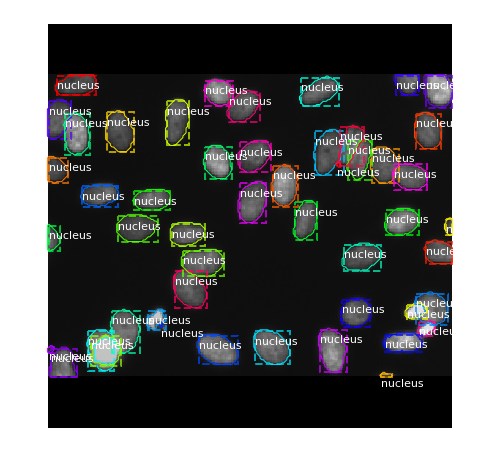

In [19]:
# Test on a random image


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [20]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  226.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  122.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


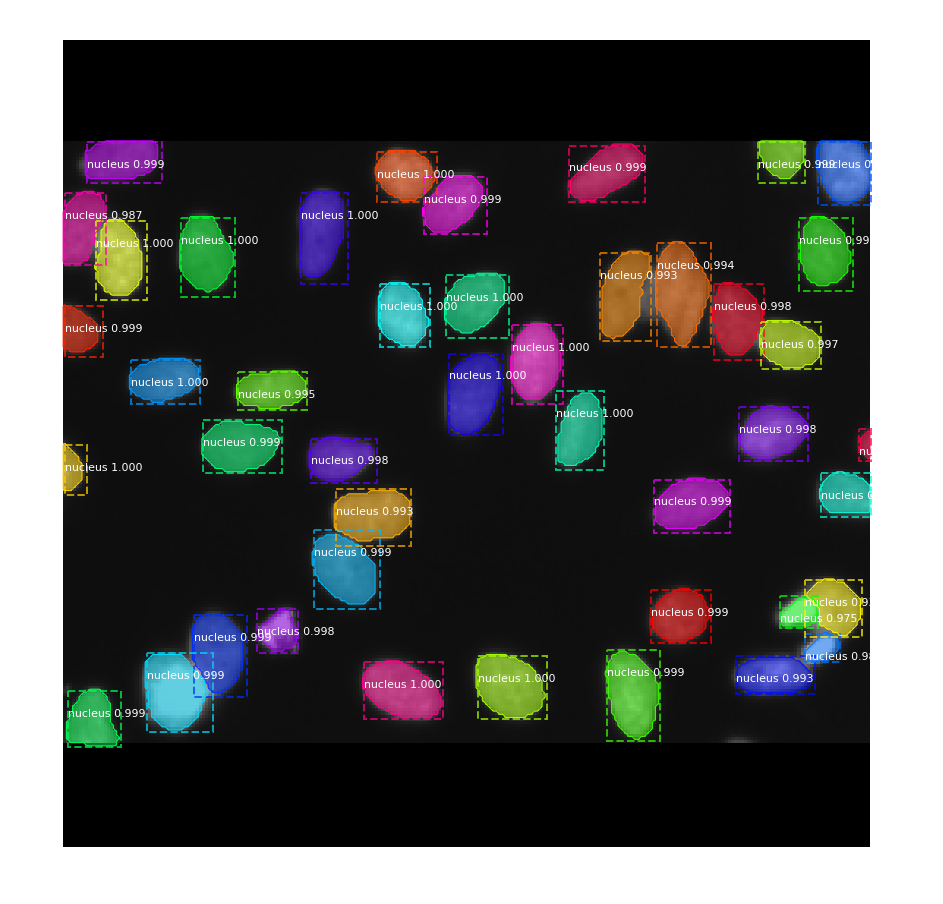

In [21]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_valid.class_names, r['scores'], ax=None)

In [22]:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_valid.image_ids, 10)
APs = []
for image_id in tqdm_notebook(image_ids):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_valid, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)



mAP:  0.780614157781


In [25]:
from tqdm import tqdm_notebook

dataset_test = DataBowlDataset()
dataset_test.load_databowl('../dataset/stage1_test')
dataset_test.prepare()

In [90]:
#get result for masked image
mask_images = []
for image_id in tqdm_notebook(dataset_test.image_ids):
    image = dataset_test.load_image(image_id)
    results = model.detect([image], verbose=0)
    r = results[0]
    mask_shape = r['masks'].shape
    mask_image = np.zeros((mask_shape[0], mask_shape[1]))
    for i in range(mask_shape[2]):
        mask_image[:,:] = np.where(r['masks'][:,:,i]==1, 1, mask_image[:,:]) 
    mask_images.append(mask_image)

HBox(children=(IntProgress(value=0, max=65), HTML(value='')))

Exception in thread Thread-14:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



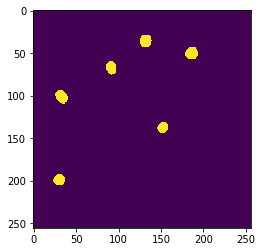

In [91]:
plt.imshow(mask_images[64])

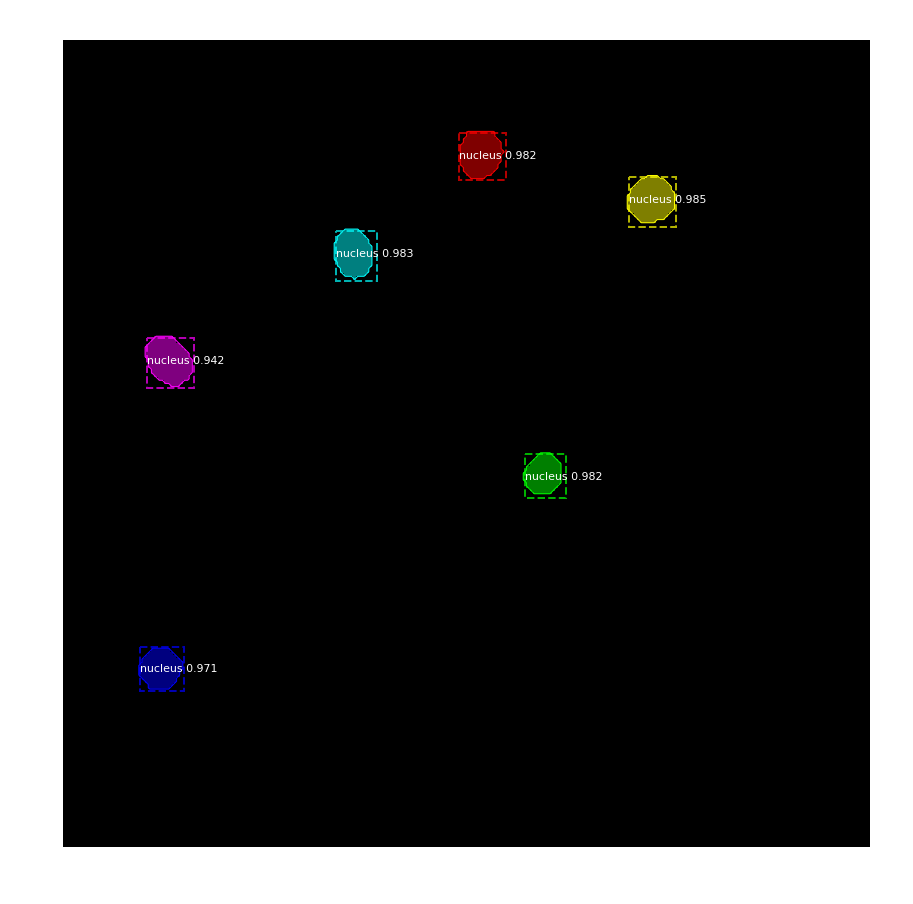

In [92]:
#Test of Images
image_idx = 64
original_image = dataset_test.load_image(dataset_test.image_ids[image_idx])
results = model.detect([original_image], verbose=0)
visualize.display_instances(original_image, results[0]['rois'], results[0]['masks'], results[0]['class_ids'], dataset_test.class_names, results[0]['scores'], ax=None)

In [30]:
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [101]:
new_test_ids = []
rles = []
for n, id_ in tqdm_notebook(enumerate(dataset_test.image_ids)):
    rle = list(prob_to_rles(mask_images[n]))
    #rle = list(rle_encoding(mask_images[n]))
    rles.extend(rle)
    new_test_ids.extend([dataset_test.image_info[n]['id']] * len(rle))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [103]:
sub1 = pd.DataFrame({'ImageId':new_test_ids})
sub1['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x ))

In [84]:
sub1.to_csv('submission_1.csv', index=False)